In [1]:
from numpy.random import seed
seed(101)
#from tensorflow import set_random_seed
#set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform
from tensorflow import keras
from sklearn.utils import shuffle
#from sklearn.metrics import confusion_matrix
#from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive, files

drive.mount('/drive')

Mounted at /drive


# Check Samples dataset 
* here we will display few samples 
* convert dataset from directory setup into dataFrame  

In [3]:
os.listdir('/drive/My Drive/ColabNotebooks/GMD_0/training_Classes/')

['Glaucoma', 'Normal', 'Myopia', 'DiabeticRetinopathy']

In [4]:
folder_list = os.listdir('/drive/My Drive/ColabNotebooks/GMD_0//training_Classes/')

total_images = 0

for folder in folder_list:
  #/drive/My Drive/dataset/train/
    path = '/drive/My Drive/ColabNotebooks/GMD_0/training_Classes/' + str(folder)
    images_list = os.listdir(path)
    num_images = len(images_list)
    
    total_images = total_images + num_images
    print(str(folder) + ':' + ' ' + str(num_images))
    
print('\n')
print('Total Images: ', total_images)
    

Glaucoma: 501
Normal: 510
Myopia: 502
DiabeticRetinopathy: 539


Total Images:  2052


In [5]:
all_images_dir = 'all_images'
os.mkdir(all_images_dir)

In [6]:
import shutil
folder_list = os.listdir('/drive/My Drive/ColabNotebooks/GMD_0/training_Classes/')

for folder in folder_list:
    
    # create a path to the folder
    path = '/drive/My Drive/ColabNotebooks/GMD_0/training_Classes/' + str(folder)

    # create a list of all files in the folder
    file_list = os.listdir(path)

    # move the 0 images to all_images_dir
    for fname in file_list:

        # source path to image
        src = os.path.join(path,fname)
        
        # Change the file name because many images have the same file name.
        # Add the folder name to the existing file name.
        new_fname = str(folder) + '_' + fname
        
        # destination path to image
        dst = os.path.join(all_images_dir,new_fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [7]:
# Check how many images are in all_images_dir.
# Should be 5539.

len(os.listdir('all_images'))

2052

In [8]:
# Get a list of all images in the all_images_dir folder.
image_list = os.listdir('all_images')

# Create the dataframe.
df_file = pd.DataFrame(image_list, columns=['image_id'])
def extract_target(x):
    # split into a list
    a = x.split('_')
    #b = y.split('_')
    # the target is the first index in the list
    target = a[0]

    #Labels=b[0:4]
    
    return target

# create a new column called 'target'
df_file['Classes'] = df_file['image_id'].apply(extract_target)
#df_data['DiabeticRetinopathy','Myopia','Glaucoma','Normal'].apply(extract_target)
dum_df = pd.get_dummies(df_file.Classes, prefix=None )
#df_data = df_data.join(dum_df)
dum_df = pd.get_dummies(df_file.Classes, prefix=None )
df_data =df_file.join(dum_df)

In [9]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=plt.imread(file)
            ax[i, j].imshow(im,cmap=None,)
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

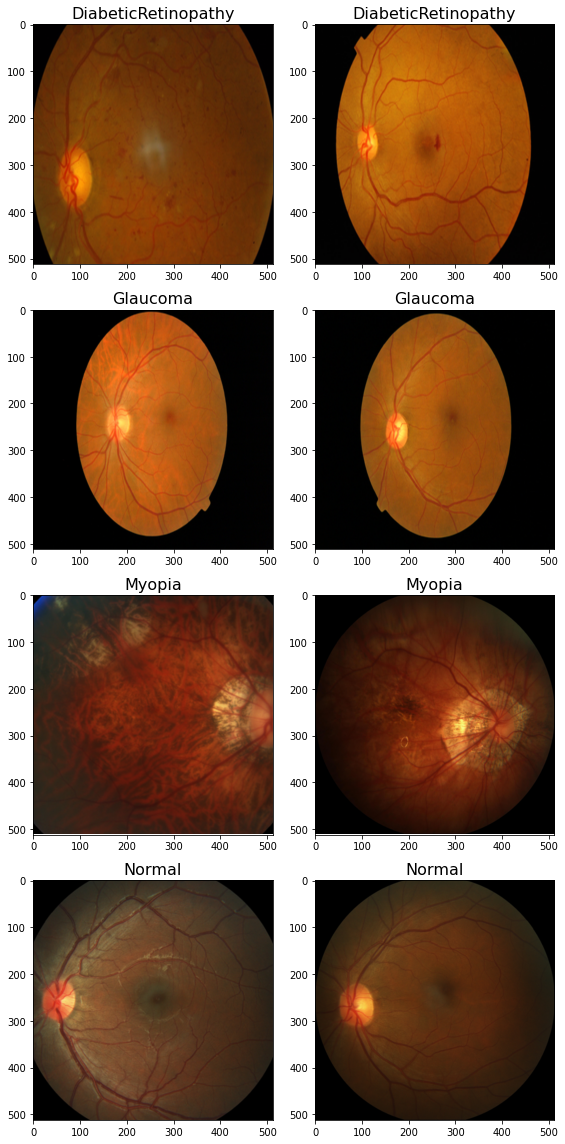

In [10]:
IMAGE_PATH = 'all_images/'
draw_category_images('Classes',2, df_data, IMAGE_PATH)

In [11]:
df_data['Classes'].value_counts()
num_labels=["DiabeticRetinopathy","Glaucoma","Myopia","Normal"]

# Per-Processing Dataset by spliting Distrubtions data into (x,y) 
* x_train repersent data point y_train labesl target as long as dealing with suprivoser learnikng
* here to keep tracking labels and smoothing labels will encode labels using One-Hot-encoding 

In [101]:
# Initiate the train and test generators with data Augumentation
from imgaug import augmenters as iaa
# Initiate the train and test generators with data Augumentation
sometimes = lambda aug: iaa.Sometimes(1, aug)
seq = iaa.Sequential([
                      iaa.AllChannelsCLAHE(),
                      #iaa.AllChannelsHistogramEqualization()
                      #iaa.AllChannelsHistogramEqualization(),
            
                    ])

In [104]:
from tqdm import tqdm
from keras.preprocessing import image
train_image = []

for i in tqdm(range(df_data.shape[0])):
    scr= cv2.imread('all_images/'+df_data['image_id'][i])
    grayA = cv2.cvtColor(scr, cv2.COLOR_RGB2GRAY)
    images = cv2.resize(grayA ,(128,128))
    aug_img=seq(images=images)
    aug_img = image.img_to_array(aug_img)
    aug_img = aug_img/255
    train_image.append(aug_img)
X = np.array(train_image)

100%|██████████| 2052/2052 [00:18<00:00, 109.35it/s]


In [105]:
X.shape

(2052, 128, 128, 1)

In [106]:
from sklearn.model_selection import train_test_split
#df_data['Classes'][:4]
y = np.array(df_data.drop(['image_id', 'Classes'],axis=1))
y.shape

(2052, 4)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [108]:
y_test.shape

(411, 4)

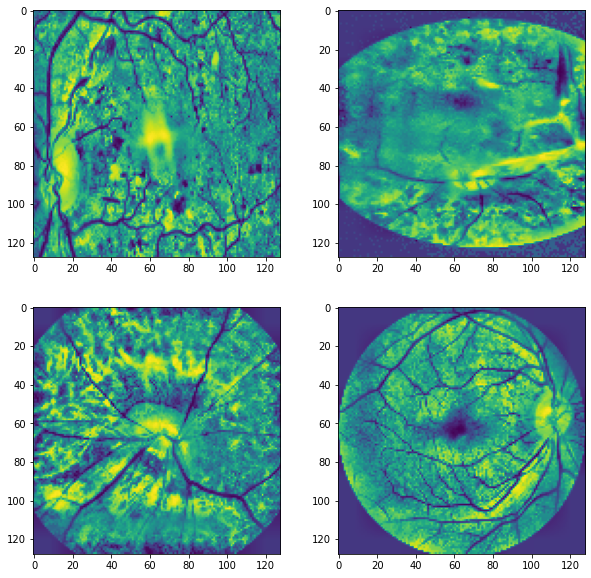

In [109]:
w = 10
h = 10
fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_image[i][:,:,0])
plt.show()

# Costume Layer Augmentation  and model desing 

In [110]:
image_size = X_train.shape[1]
 

In [120]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters_1 = 64
filters_2 = 64
filters_3 = 128
filters_4= 256

dropout = 0.25

In [112]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten ,ZeroPadding2D
from tensorflow.keras.models import Model
from keras.regularizers import l2

In [123]:
# use functional API to build cnn layers
inputs = Input(shape=input_shape)
#augmented = data_augmentation(inputs)


y = Conv2D(filters=filters_1,kernel_size= kernel_size,activation='relu',
           kernel_regularizer=l2(0.01), 
           bias_regularizer=l2(0.01))(inputs)
y = ZeroPadding2D(padding=(1,1))(y)

y = Conv2D(filters=filters_1,kernel_size=kernel_size, activation='relu',
           kernel_regularizer=l2(0.01), 
           bias_regularizer=l2(0.01))(y)
y = MaxPooling2D(pool_size=(2,2))(y)

y = Conv2D(filters=filters_2,kernel_size=kernel_size,activation='relu',
           kernel_regularizer=l2(0.01), 
           bias_regularizer=l2(0.01))(y)
y = ZeroPadding2D(padding=(1,1))(y)
y = Dropout(dropout)(y) 


y = Conv2D(filters=filters_2,kernel_size=kernel_size, activation='relu',
           kernel_regularizer=l2(0.01),
           bias_regularizer=l2(0.01))(y)
y = MaxPooling2D(pool_size=(2,2))(y)
y = BatchNormalization()(y)

y = Conv2D(filters=filters_3,kernel_size=kernel_size,activation='relu',
           kernel_regularizer=l2(0.01),
           bias_regularizer=l2(0.01))(y)
y = ZeroPadding2D(padding=(1,1))(y)



y = Conv2D(filters=filters_3,kernel_size=kernel_size,activation='relu',
           kernel_regularizer=l2(0.01), 
           bias_regularizer=l2(0.01))(y)
y = MaxPooling2D(pool_size=(2,2))(y)
y = Dropout(dropout)(y)

#y = Conv2D(filters=filters_4,kernel_size=kernel_size,activation='relu')(y)
#y = MaxPooling2D(pool_size=(2,2))(y)
#y = BatchNormalization()(y)

y = Conv2D(filters=filters_4, kernel_size=kernel_size,activation='relu')(y)
# image to vector before connecting to dense layer
y = Flatten()(y)
y = Dense(300, activation='relu')(y)
y = Dropout(dropout)(y)
outputs = Dense(len(num_labels), activation='softmax')(y)

In [124]:
# # build the model by supplying inputs/outputs
from tensorflow import keras
model = Model(inputs=inputs, outputs=outputs)
keras.utils.plot_model(
    model,
    to_file="/drive/My Drive/ColabNotebooks/GMD_0/Model-summary/GMD_0_HE/GMD_Final_HE.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    show_layer_activations=True,
)

# network model in text
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 126, 126, 64)      640       
                                                                 
 zero_padding2d_12 (ZeroPadd  (None, 128, 128, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_29 (Conv2D)          (None, 126, 126, 64)      36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 61, 61, 64)        3692

In [125]:
losse=tf.keras.losses.CategoricalCrossentropy(
     label_smoothing=0.1,
    name='categorical_crossentropy'
)
from tensorflow.keras.optimizers import Adadelta,Adam

In [126]:
from matplotlib.colors import NoNorm
stop = EarlyStopping(monitor = 'loss', patience = 2, verbose = 2, mode = 'auto')


losse=tf.keras.losses.CategoricalCrossentropy(
      label_smoothing=0.1,
       name='categorical_crossentropy'
)

model.save("/drive/My Drive/ColabNotebooks/GMD_0/Model-summary/GMD_0_HE/save_GMD_Final_HE.h5",
             save_traces=True,
            include_optimizer=True
)


model.compile(
    optimizer="adam",
    loss=losse,
    metrics=["accuracy"],
)
history =model.fit(X_train, y_train, epochs=35,verbose=1,validation_split=0.2,callbacks=[stop])


Epoch 1/35
41/41 [==============================] - 9s 169ms/step - loss: 4.4446 - accuracy: 0.4573 - val_loss: 3.5354 - val_accuracy: 0.3070
Epoch 2/35
41/41 [==============================] - 6s 155ms/step - loss: 2.4155 - accuracy: 0.8178 - val_loss: 2.6878 - val_accuracy: 0.3070
Epoch 3/35
41/41 [==============================] - 6s 155ms/step - loss: 1.7129 - accuracy: 0.8941 - val_loss: 2.2026 - val_accuracy: 0.7781
Epoch 4/35
41/41 [==============================] - 6s 155ms/step - loss: 1.2827 - accuracy: 0.9665 - val_loss: 1.8793 - val_accuracy: 0.8541
Epoch 5/35
41/41 [==============================] - 6s 156ms/step - loss: 1.0287 - accuracy: 0.9825 - val_loss: 1.6477 - val_accuracy: 0.7568
Epoch 6/35
41/41 [==============================] - 6s 155ms/step - loss: 0.8642 - accuracy: 0.9939 - val_loss: 1.4525 - val_accuracy: 0.9726
Epoch 7/35
41/41 [==============================] - 6s 155ms/step - loss: 0.7544 - accuracy: 0.9977 - val_loss: 1.3413 - val_accuracy: 0.9422
Epoch 

# Analysis the Perfomence Model 
* training / Loss function plots 
* classification report 
* confusing Matrix 

In [127]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.savefig('/drive/My Drive/ColabNotebooks/GMD_0/Model-summary/GMD_0_HE/'+'performanceSeg64.png')

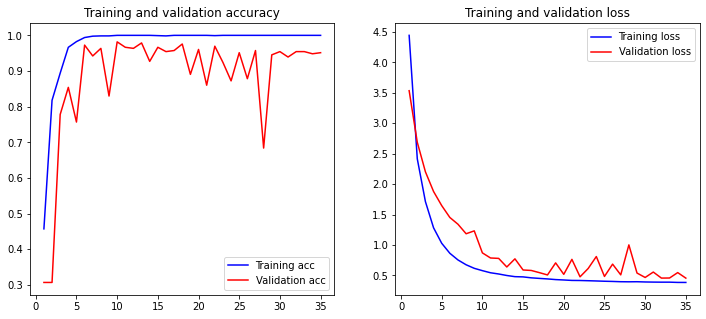

In [128]:
plot_history(history)

In [129]:
model.metrics_names

['loss', 'accuracy']

In [130]:
val_loss, val_accuracy = \
evaluate=model.evaluate(X_test, y_test,batch_size=128)
print('Vall_loss:', val_loss)
print('val_acc:', val_accuracy)

4/4 [==============================] - 4s 427ms/step - loss: 0.4369 - accuracy: 0.9708
Vall_loss: 0.43690791726112366
val_acc: 0.970802903175354


In [131]:
predictions=np.argmax(model.predict(X_test), axis=-1)

In [132]:
import pandas as pd
path_report='/drive/My Drive/ColabNotebooks/GMD_0/Model-summary/GMD_0_HE/classification_report_GMD_0.csv'
from sklearn.metrics import classification_report
from collections import defaultdict

num_labels=["DiabeticRetinopathy","Glaucoma","Myopia","Normal"]
import pandas as pd
import sklearn.metrics
import numpy as np

def classification_report(*args, **kwargs):
    out_df = pd.DataFrame(sklearn.metrics.classification_report(*args, **kwargs, output_dict=True)).T
    # Order cols
    out_df[["precision","recall","f1-score","support"]]  
    # Round
    out_df[["precision","recall","f1-score"]]= out_df[["precision","recall","f1-score"]].apply(lambda x: round(x,2))
    out_df[["support"]]= out_df[["support"]].apply(lambda x: x.astype(np.int))
    # Add suport to avg
    out_df.loc['accuracy', 'support'] = out_df.loc['weighted avg', 'support']
    return out_df

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score,confusion_matrix,matthews_corrcoef 
labelNames=['DiabeticRetinopathy','Glaucoma', 'Myopia','Normal']
print("[INFO] evaluating network...")
predictions = model.predict(X_test, batch_size=128)
out_df=pd.DataFrame(classification_report(y_test.argmax(axis=-1),predictions.argmax(axis=-1), 
                                          target_names=num_labels,output_dict=True)).T

# Order cols
out_df[["precision","recall","f1-score","support"]]  
    # Round
out_df[["precision","recall","f1-score"]]= out_df[["precision","recall","f1-score"]].apply(lambda x: round(x,2))
out_df[["support"]]= out_df[["support"]].apply(lambda x: x.astype(np.int))
    # Add suport to avg
out_df.loc['accuracy', 'support'] = out_df.loc['weighted avg', 'support']
out_df.to_csv(path_report, index = True)

[INFO] evaluating network...


In [133]:
out_df.head()

,precision,recall,f1-score,support
DiabeticRetinopathy,0.97,0.94,0.96,114
Glaucoma,0.97,1.00,0.98,98
Myopia,0.93,0.97,0.95,89
Normal,1.00,0.98,0.99,110
accuracy,0.97,0.97,0.97,411


# Prediction Outputs using Validation data generated 

In [135]:

from keras.preprocessing import image
path='/drive/My Drive/ColabNotebooks/GMD_0/Valida_data/Normal/Normal_original_NL (329).png_ed5e20eb-3e99-4a82-a4f9-ef9e67d8b107.png'

scr= cv2.imread(path)
grayA = cv2.cvtColor(scr, cv2.COLOR_RGB2GRAY)
images = cv2.resize(grayA,(128,128))
aug_img=seq(images=images)
aug_img = image.img_to_array(aug_img)
aug_img = aug_img/255
aug_img.shape  

(128, 128, 1)

DiabeticRetinopathy (0.464)
Normal (0.228)
Myopia (0.202)


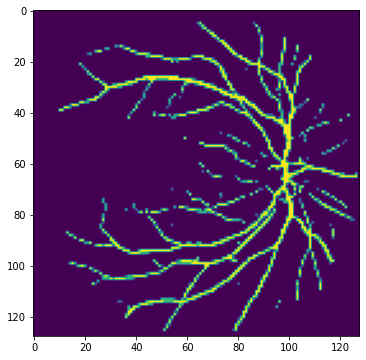

In [138]:
#classes= np.array((df_data.columns[2:]))
classes=['DiabeticRetinopathy','Glaucoma', 'Myopia','Normal']

proba = model.predict(aug_img.reshape(1,128,128,1))
top_4 = np.argsort(proba[0],kind ='heapsort', axis = -1)[:-4:-1]
reusult=[]
for i in range(3):
    print("{}".format(classes[top_4[i]])+" ({:.3})".format(proba[0][top_4[i]]))
    reusult.append("{}".format(classes[top_4[i]])+" ({:.3})".format(proba[0][top_4[i]]))
plt.figure(figsize=(6,6))    
plt.imshow(aug_img[:,:,0])
#plt.figure(figsize=(10,10))